In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import pyodbc
import warnings

warnings.filterwarnings("ignore")

def remove_outliers(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_num: pd.DataFrame = df.select_dtypes(include=numerics)
    for colname in df_num.columns:
        Q1 = df[colname].quantile(0.25)
        Q3 = df[colname].quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df[colname]<(Q1-1.5*IQR))|(df[colname]>(Q3+1.5*IQR)))]
    return df

In [22]:
data = pd.read_csv('model_data.csv', index_col='TOTOID')

In [23]:
data

,DepositCount,DepositAmount,Age,Category,One_game,Second_game
TOTOID,,,,,,
100377572,21,5200.0,24,Slots,True,Betongames
100377577,96,274170.0,57,Sports,True,Betongames
100377612,33,248372.0,45,P2P,True,Slots
100377613,143,443500.0,59,Slots,True,Betongames
100377617,500,2797000.0,42,Slots,True,NaN
...,...,...,...,...,...,...
101242827,2,3000.0,26,Live Casino,True,Slots
101242831,1,10000.0,64,Slots,True,Betongames
101242837,1,1000.0,37,Slots,False,Betongames


In [24]:
data = remove_outliers(data)

In [25]:
data

,DepositCount,DepositAmount,Age,Category,One_game,Second_game
TOTOID,,,,,,
100377572,21,5200.0,24,Slots,True,Betongames
100377622,13,27600.0,32,Sports,True,Slots
100377628,30,12055.0,24,Sports,True,Slots
100377633,1,1000.0,27,P2P,True,NaN
100377638,77,69600.0,24,P2P,False,Slots
...,...,...,...,...,...,...
101242827,2,3000.0,26,Live Casino,True,Slots
101242831,1,10000.0,64,Slots,True,Betongames
101242837,1,1000.0,37,Slots,False,Betongames


In [26]:
data['One_game'] = data['One_game'].astype(int)

In [27]:
data = pd.get_dummies(data, prefix=['main', 'second'])

In [28]:
data.head()

,DepositCount,DepositAmount,Age,One_game,main_Betongames,main_Live Casino,main_Other,main_P2P,main_Slots,main_Sports,main_TVGames,main_Virtual Games,second_Betongames,second_Live Casino,second_Other,second_P2P,second_Slots,second_Sports,second_TVGames,second_Virtual Games
TOTOID,,,,,,,,,,,,,,,,,,,,
100377572,21,5200.0,24,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
100377622,13,27600.0,32,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
100377628,30,12055.0,24,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
100377633,1,1000.0,27,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
100377638,77,69600.0,24,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


## MinMaxScaler

In [29]:
from sklearn.preprocessing import MinMaxScaler
minmaxdf = data
scaler = MinMaxScaler()
scaler.fit(minmaxdf[['DepositCount', 'DepositAmount', 'Age']])
minmaxdf[['DepositCount', 'DepositAmount', 'Age']] = scaler.transform(minmaxdf[['DepositCount', 'DepositAmount', 'Age']])
minmaxdf.head()

,DepositCount,DepositAmount,Age,One_game,main_Betongames,main_Live Casino,main_Other,main_P2P,main_Slots,main_Sports,main_TVGames,main_Virtual Games,second_Betongames,second_Live Casino,second_Other,second_P2P,second_Slots,second_Sports,second_TVGames,second_Virtual Games
TOTOID,,,,,,,,,,,,,,,,,,,,
100377572,0.148148,0.041185,0.12,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
100377622,0.088889,0.221972,0.28,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
100377628,0.214815,0.096511,0.12,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
100377633,0.000000,0.007288,0.18,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
100377638,0.562963,0.560947,0.12,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [30]:
minmaxdf.describe()

,DepositCount,DepositAmount,Age,One_game,main_Betongames,main_Live Casino,main_Other,main_P2P,main_Slots,main_Sports,main_TVGames,main_Virtual Games,second_Betongames,second_Live Casino,second_Other,second_P2P,second_Slots,second_Sports,second_TVGames,second_Virtual Games
count,129741.000000,129741.000000,129741.000000,129741.000000,129741.000000,129741.000000,129741.000000,129741.000000,129741.000000,129741.000000,129741.000000,129741.000000,129741.000000,129741.000000,129741.000000,129741.000000,129741.000000,129741.000000,129741.000000,129741.000000
mean,0.138432,0.177883,0.376514,0.781912,0.139008,0.016094,0.003168,0.042654,0.718624,0.078603,0.001372,0.000478,0.564964,0.020618,0.026322,0.033282,0.216069,0.038330,0.001935,0.001526
std,0.183702,0.228690,0.230631,0.412949,0.345956,0.125836,0.056195,0.202077,0.449672,0.269119,0.037015,0.021855,0.495764,0.142102,0.160091,0.179372,0.411563,0.191993,0.043942,0.039036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.014815,0.018829,0.200000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.059259,0.075083,0.320000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.185185,0.246992,0.500000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


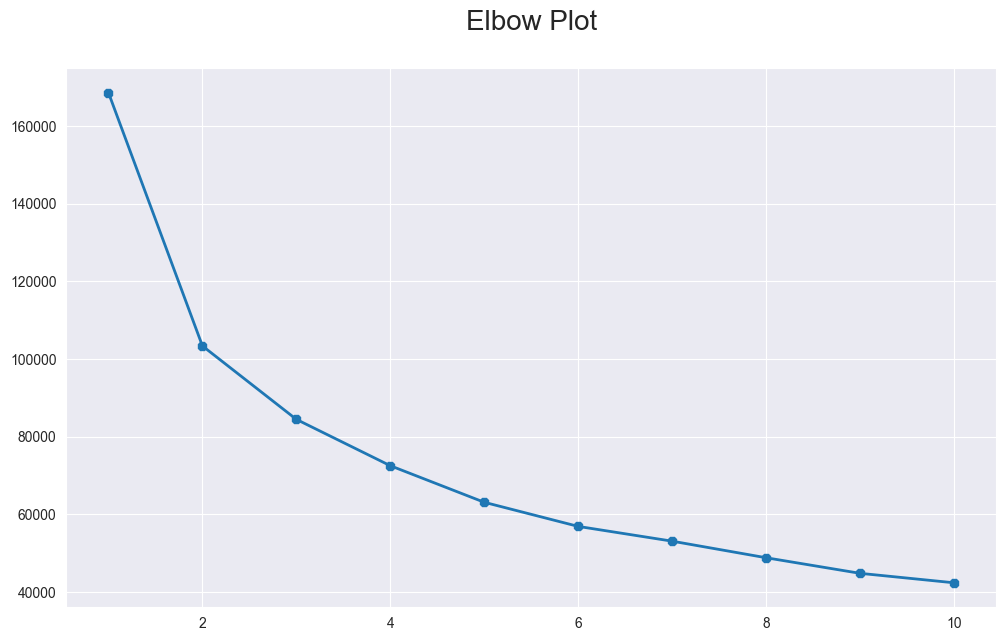

In [31]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(minmaxdf)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12, 7))

plt.plot(range(1, 11), wcss, linewidth=2, marker='8')
plt.title('Elbow Plot\n', fontsize=20)
plt.show()

In [32]:
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(minmaxdf)
minmaxdf['label'] = clusters

In [33]:
minmaxdf['label'].value_counts()

0    73249
1    31373
2    25119
Name: label, dtype: int64

In [34]:
minmaxdf.to_excel('MinMaxScaler_3Clusters.xlsx')

In [36]:
data.drop(columns='label', inplace=True)

KeyError: "['label'] not found in axis"

In [37]:
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(minmaxdf)
minmaxdf['label'] = clusters

In [38]:
minmaxdf['label'].value_counts()

2    71545
0    23473
1    18035
3    16688
Name: label, dtype: int64

In [39]:
minmaxdf.to_excel('MinMaxScaler_4Clusters.xlsx')

In [40]:
data.drop(columns='label', inplace=True)
minmaxdf.drop(columns=['label'], inplace=True)

KeyError: "['label'] not found in axis"

In [ ]:
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(minmaxdf)
minmaxdf['label'] = clusters

In [ ]:
minmaxdf['label'].value_counts()

In [ ]:
minmaxdf.to_excel('MinMaxScaler_5Clusters.xlsx')

## Standard Scaler

In [ ]:
data.drop(columns='label', inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler
standarddf = data
scaler = StandardScaler()
scaler.fit(standarddf[['DepositCount', 'DepositAmount', 'Age']])
standarddf[['DepositCount', 'DepositAmount', 'Age']] = scaler.transform(standarddf[['DepositCount', 'DepositAmount', 'Age']])
standarddf.head()

In [ ]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(standarddf)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12, 7))

plt.plot(range(1, 11), wcss, linewidth=2, marker='8')
plt.title('Elbow Plot\n', fontsize=20)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(standarddf)
standarddf['label'] = clusters

In [ ]:
standarddf.label.value_counts()